# LSST SRD Redshift Distributions and Tomographic Binning
Use this notebook to generate the LSST SRD* redshift distributions (source and lens galaxy samples ofr appropriate LSST epochs) and to perform the tomographic binning of those samples.

*SRD stands for [Science Requirements Document](https://arxiv.org/abs/1809.01669)

In [1]:
import cmasher as cmr
import matplotlib.pyplot as plt
import numpy as np
from lsst_galaxy_sample import LSSTGalaxySample as lsst

## Note on the SRD Redshift Distributions

The overall redshift distribution of galaxies for LSST follows a Smail-type parameterization:

\begin{equation}
N (z) = \left( \frac{z}{z_0}  \right) ^\beta \exp \left[ - \left( \frac{z}{z_0}  \right) ^\alpha\right] ,
\end{equation}

where $z$ is the redshift, $z_0$ is the pivot redshift, and $ \alpha $ and $ \beta $ are power-law indices. The pivot redshift and power-law indices differ between lens and source galaxies and depend on the forecast year. These values are stored in the `lsst_desc_parameters.yaml` file, with details available in the [LSST DESC Science Requirements Document (SRD)](https://arxiv.org/abs/1809.01669).

The total number density of galaxies, $ n_{\text{gal}} $, represents the density of galaxies per $\mathrm{arc min^2}$ and is used to scale the normalized redshift distribution, yielding $ \mathrm{d}N / \mathrm{d} z $, the galaxy number density as a function of redshift:

\begin{equation}
\frac{\mathrm{d} N}{ \mathrm{d}z} = n_{\text{gal}} \cdot p(z) ,
\end{equation}

where $ p(z) $ is the normalized Smail-type distribution. The normalization ensures that the probability distribution integrates to 1 before being rescaled by $ n_{\text{gal}} $.

For tomographic binning, the observed redshift distribution accounts for photometric uncertainties. This is done by convolving the intrinsic redshift distribution with a photometric error model:

\begin{equation}
p(z_{\text{phot}} | z) = \frac{1}{2} p(z) \left[ \text{erf} \left( \frac{z_{\text{max}} - z + z_{\text{bias}}}{\sqrt{2} \sigma_z} \right) - \text{erf} \left( \frac{z_{\text{min}} - z + z_{\text{bias}}}{\sqrt{2} \sigma_z} \right) \right] ,
\end{equation}

where $ z_{\text{bias}} $ is the photometric bias and $ \sigma_z $ is the photometric scatter, both of which depend on the sample type (lens or source). For more details, see [Ma, Hu & Huterer 2005](https://arxiv.org/abs/astro-ph/0506614).

For lens galaxies, the tomographic bins are defined by fixed redshift intervals, while source galaxies are divided into bins containing an equal number of galaxies. The bin edges for source galaxies are determined by integrating the cumulative redshift distribution and selecting boundaries that ensure equal galaxy counts in each bin.


## Generating the Data

The `LSSTGalaxySample` class provides key redshift distribution products for LSST forecasts, including:

- **Lens and source samples** (`numpy.ndarray`): The redshift distributions of lens and source galaxies.
- **Tomographically binned samples** (`dict`): Redshift distributions split into lens and source bins.
- **Bin centers** (`dict`): Frequently used in analyses, these are readily available in the code

The class supports all relevant LSST forecast years and is initialized with:
1. **Forecast year** (required, as `str`) – available options: `"1"`, `"4"`, `"7"`, and `"10"`.
2. **Redshift range** (optional, as `array`) – if not provided, the default is: $ \text{redshift\_range} = \text{np.linspace}(0, 3.5, 500) $

Below, we generate the redshift distributions and tomographic bins for the LSST source and lens samples.

By default:
- All distributions, including $N(z)$ and tomographic bins, are **normalized**.
- Tomo bin centers are rounded to **two decimal places**.
- The generated files are **automatically saved**.

The arguments are explicitly specified below for clarity, though they reflect the default behavior.



In [2]:
# Define the redshift interval and forecast years
redshift_range = np.linspace(0.0, 3.5, 500)
forecast_years = ["1", "10"]  # LSST forecasting epochs
samples = {}

# Loop over forecast years and store the data into a dictionary
for year in forecast_years:
    init = lsst(year, redshift_range)
    samples[year] = {
        "source_nz": init.source_sample(normalized=True, save_file=True),
        "lens_nz": init.lens_sample(normalized=True, save_file=True),
        "source_bins": init.source_bins(normalized=True, save_file=True),
        "lens_bins": init.lens_bins(normalized=True, save_file=True),
        "source_bin_centers": init.source_bin_centers(decimal_places=3),
        "lens_bin_centers": init.lens_bin_centers(decimal_places=3)
    }

# If you want to access the redshift distributions, tomographic bins and bin centers
# for LSST Y1 source sample, you can do so by calling the following (uncomment the ines below):
# source_sample_y1 = samples["1"]["source_nz"]  # to get the Y1 source N(z)
# lens_bins_y1 = samples["1"]["lens_bins"]  # to get the Y1 lens bins
# lens_bin_centers_y10 = samples["10"]["lens_bin_centers"]  # to get the Y10 centers of lens bins

In [3]:
# Let us also generate the unnormalized data
samples_unnormalized = {}

# Loop over forecast years and store the data into a dictionary
for year in forecast_years:
    init = lsst(year, redshift_range)
    samples_unnormalized[year] = {
        "source_nz": init.source_sample(normalized=False, save_file=False),
        "lens_nz": init.lens_sample(normalized=False, save_file=False),
        "source_bins": init.source_bins(normalized=False, save_file=False),
        "lens_bins": init.lens_bins(normalized=False, save_file=False),
        "source_bin_centers": init.source_bin_centers(),
        "lens_bin_centers": init.lens_bin_centers()
    }

# Plot the Results

In [4]:
# Let us set up some plotting params here
plt.rcParams.update({
    "lines.linewidth": 3,
    "axes.labelsize": 25,
    "axes.titlesize": 28,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 15
})

# Define colors for plots
colors = {
"lenses": {
    "1": cmr.take_cmap_colors('cmr.freeze', len(samples["1"]["lens_bins"]),
                              cmap_range=(0.2, 0.85), return_fmt='hex'),
    "10": cmr.take_cmap_colors('cmr.freeze', len(samples["10"]["lens_bins"]),
                               cmap_range=(0.2, 0.85), return_fmt='hex')},
"sources": {
    "1": cmr.take_cmap_colors('cmr.ember', len(samples["1"]["source_bins"]),
                              cmap_range=(0.2, 0.85), return_fmt='hex'),
    "10": cmr.take_cmap_colors('cmr.ember', len(samples["10"]["source_bins"]),
                               cmap_range=(0.2, 0.85), return_fmt='hex')}}


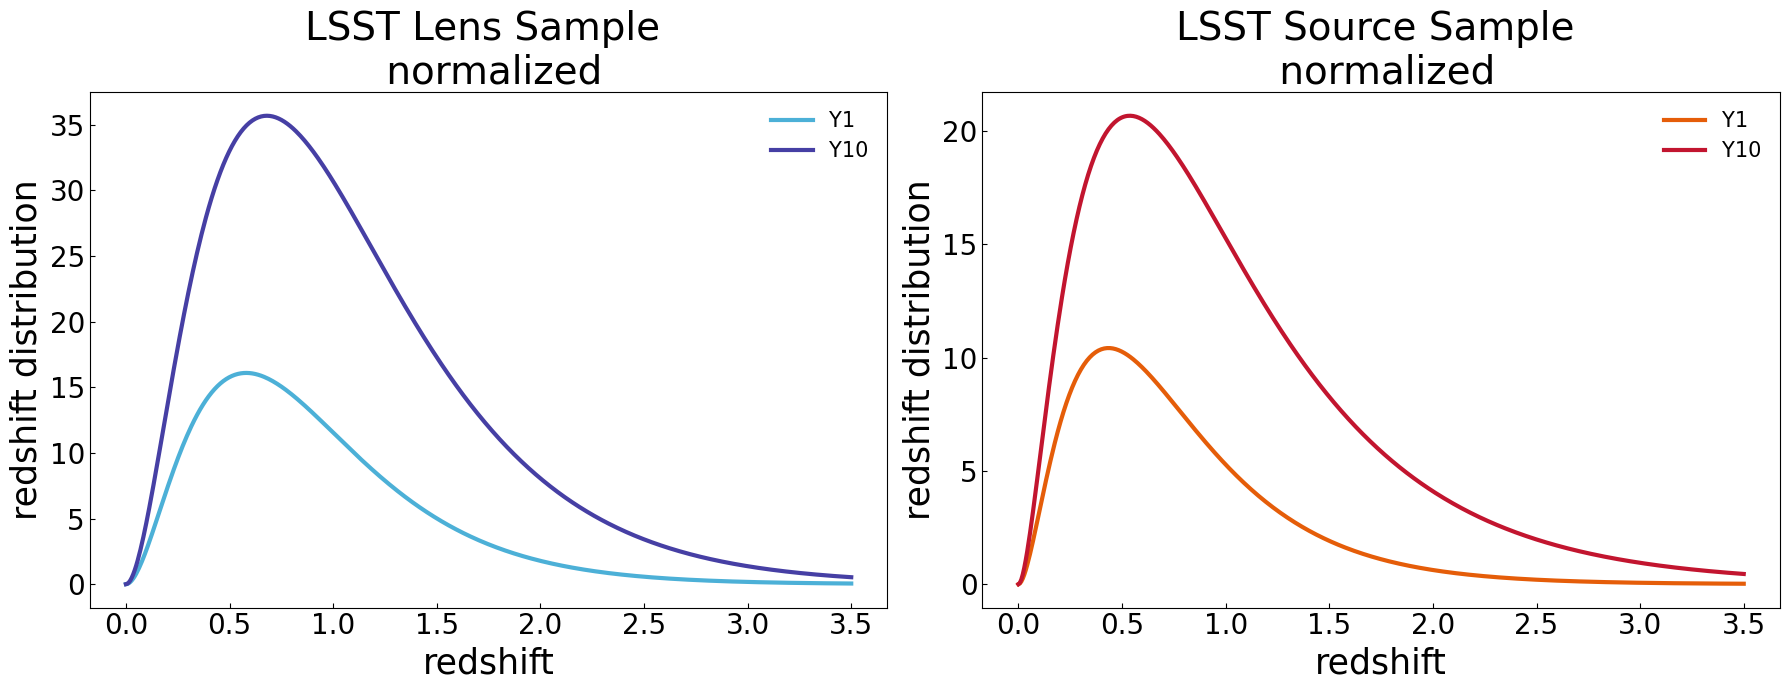

In [5]:
# Key mapping for new method
key_map = {'sources': "source_nz",
           'lenses': "lens_nz"}
norm_key = "normalized"
titles = {'sources': f'LSST Source Sample \n {norm_key}',
          'lenses': f'LSST Lens Sample \n {norm_key}'}

# Create 1x2 grid of subplots (one for sources, one for lenses)
fig, axs = plt.subplots(1, 2, figsize=(18, 7), sharex=True)

# Loop through sample types and overlay both methods
for ax, sample_type in zip(axs, ["lenses", "sources"]):
    # Select second and second-to-last colors from the colormap lists
    y1_color = colors[sample_type]["1"][-2]
    y10_color = colors[sample_type]["10"][2]

    ax.plot(redshift_range, samples["1"][key_map[sample_type]], label='Y1', color=y1_color)
    ax.plot(redshift_range, samples["10"][key_map[sample_type]], label='Y10', color=y10_color)

    # Labels & styling
    ax.set_title(titles[sample_type])
    ax.set_xlabel('redshift')
    ax.set_ylabel('redshift distribution')
    ax.tick_params(direction='in')
    ax.legend(frameon=False)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


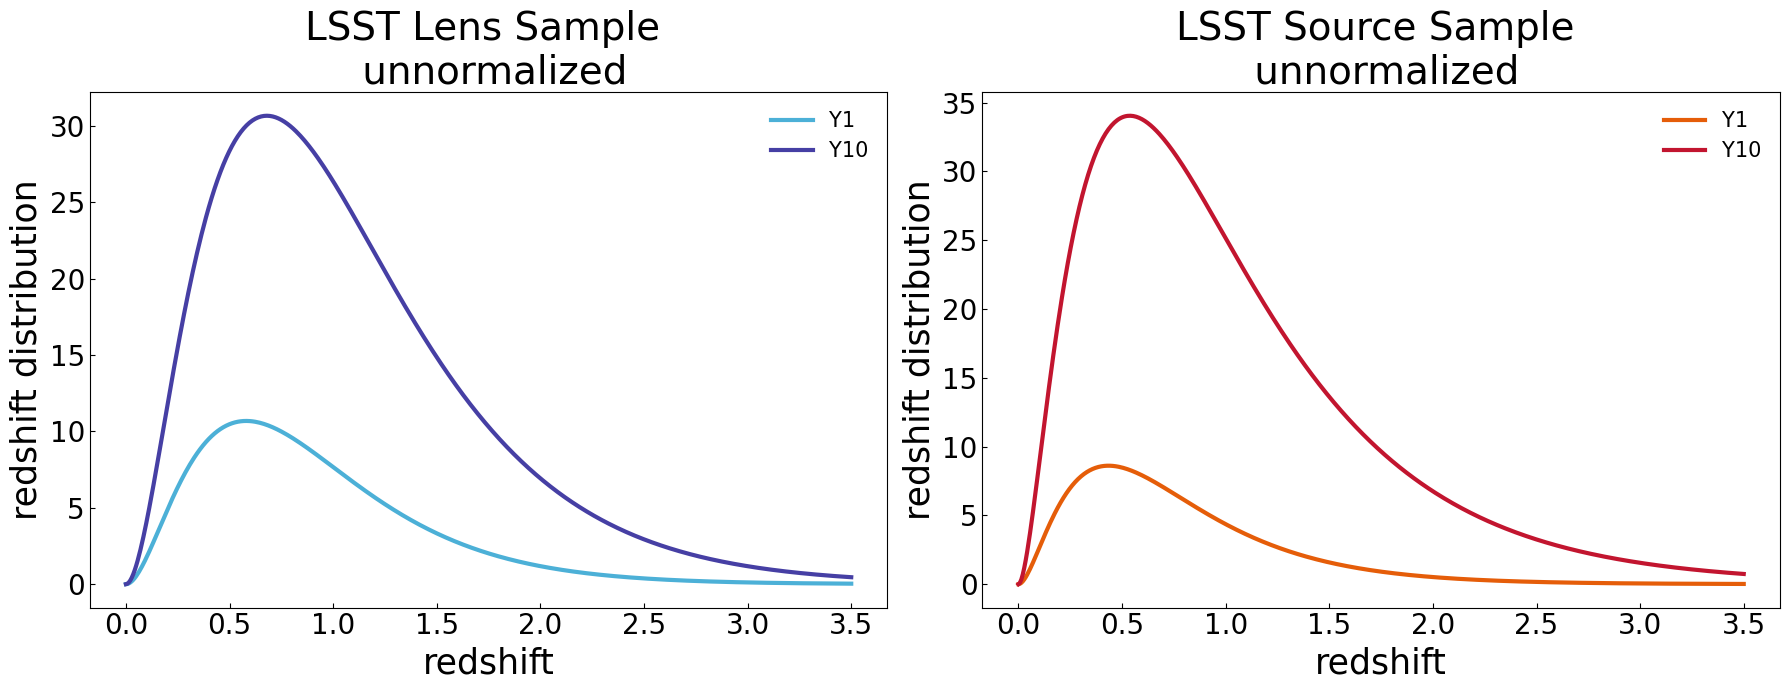

In [6]:
# Here we plot the unnormalized distributions

# Key mapping for new method
key_map = {'sources': "source_nz",
           'lenses': "lens_nz"}
unnorm_key = "unnormalized"
titles = {'sources': f'LSST Source Sample \n {unnorm_key}',
          'lenses': f'LSST Lens Sample \n {unnorm_key}'}

# Create 1x2 grid of subplots (one for sources, one for lenses)
fig, axs = plt.subplots(1, 2, figsize=(18, 7), sharex=True)

# Loop through sample types and overlay both methods
for ax, sample_type in zip(axs, ["lenses", "sources"]):
    # Select second and second-to-last colors from the colormap lists
    y1_color = colors[sample_type]["1"][-2]
    y10_color = colors[sample_type]["10"][2]

    ax.plot(redshift_range, samples_unnormalized["1"][key_map[sample_type]], label='Y1', color=y1_color)
    ax.plot(redshift_range, samples_unnormalized["10"][key_map[sample_type]], label='Y10', color=y10_color)

    # Labels & styling
    ax.set_title(titles[sample_type])
    ax.set_xlabel('redshift')
    ax.set_ylabel('redshift distribution')
    ax.tick_params(direction='in')
    ax.legend(frameon=False)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


## Plot the Tomographic Bins
Plot the results to inspect visually. We will only plot the normalized bins. You can plot the unnormalized ones but simply loading the data from the `samples_unnormalized` dictionary.

### Lens Tomo Bins

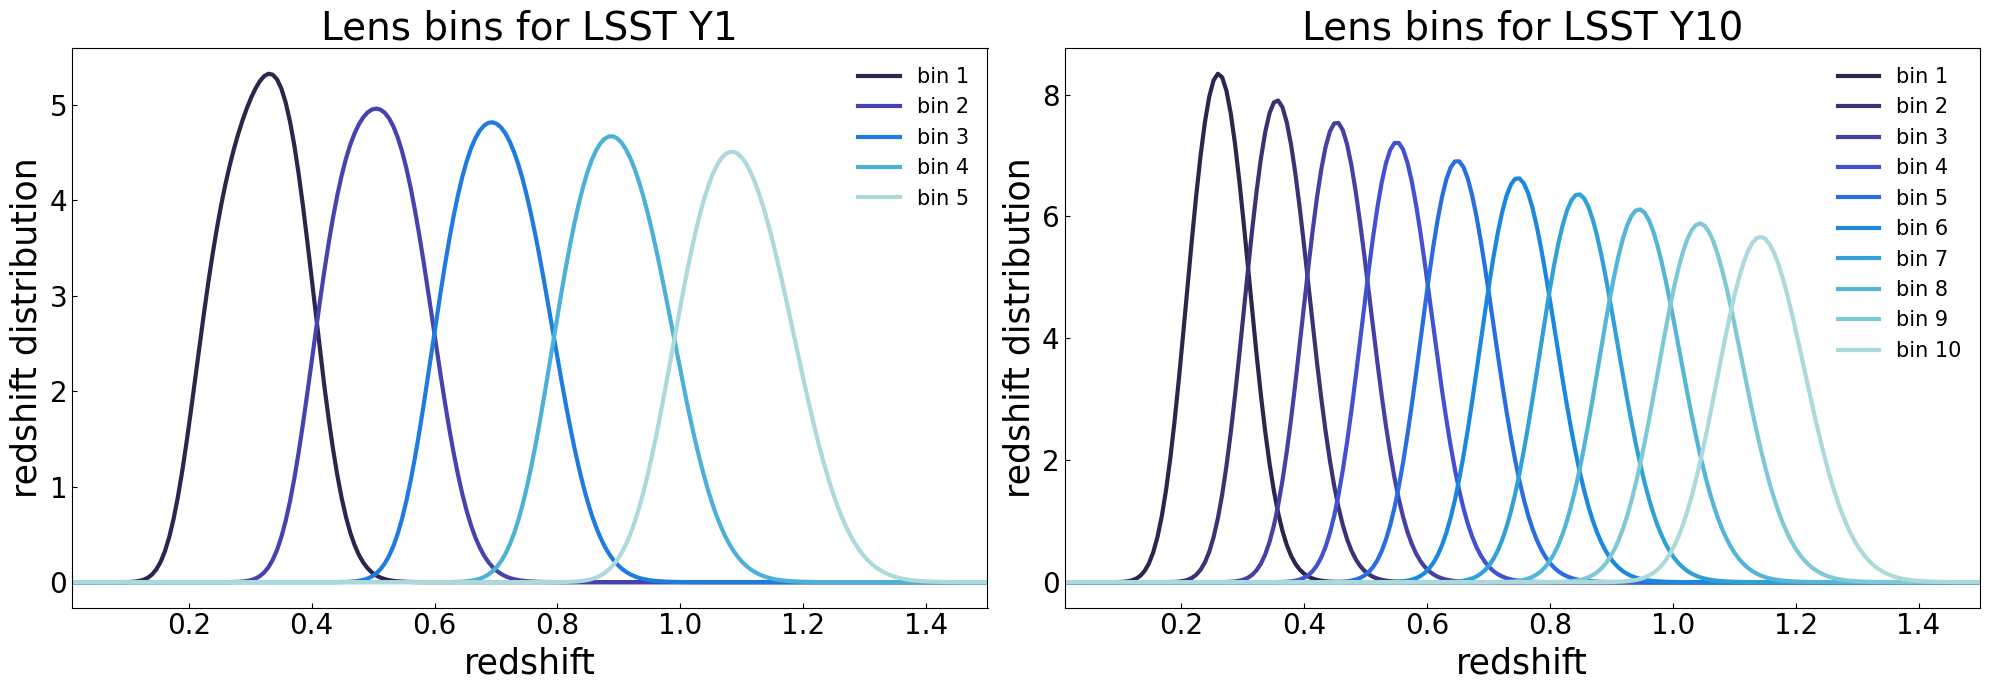

In [7]:
# Define parameters
years = ["1", "10"]
bin_type = "lens_bins"
sample_type = "lenses"

fig, axes = plt.subplots(1, 2, figsize=(20, 7))

for idx, year in enumerate(years):
    ax = axes[idx]
    for bin_idx, (key, data) in enumerate(samples[year][bin_type].items()):
        ax.plot(redshift_range,
                data,
                label=f"bin {key+1}",
                color=colors[sample_type][year][bin_idx],
                linestyle='-',
                lw=3)

    ax.set_xlim(0.01, 1.5)  # Set the x-axis limits since lens bins are defined in this range
    ax.set_xlabel("redshift")
    ax.set_ylabel("redshift distribution")
    ax.set_title(f"Lens bins for LSST Y{year}")
    ax.tick_params(direction='in')
    ax.legend(frameon=False, ncol=1)
    ax.tick_params(axis='both', which='major')

plt.tight_layout()
plt.show()


### Source Tomo Bins

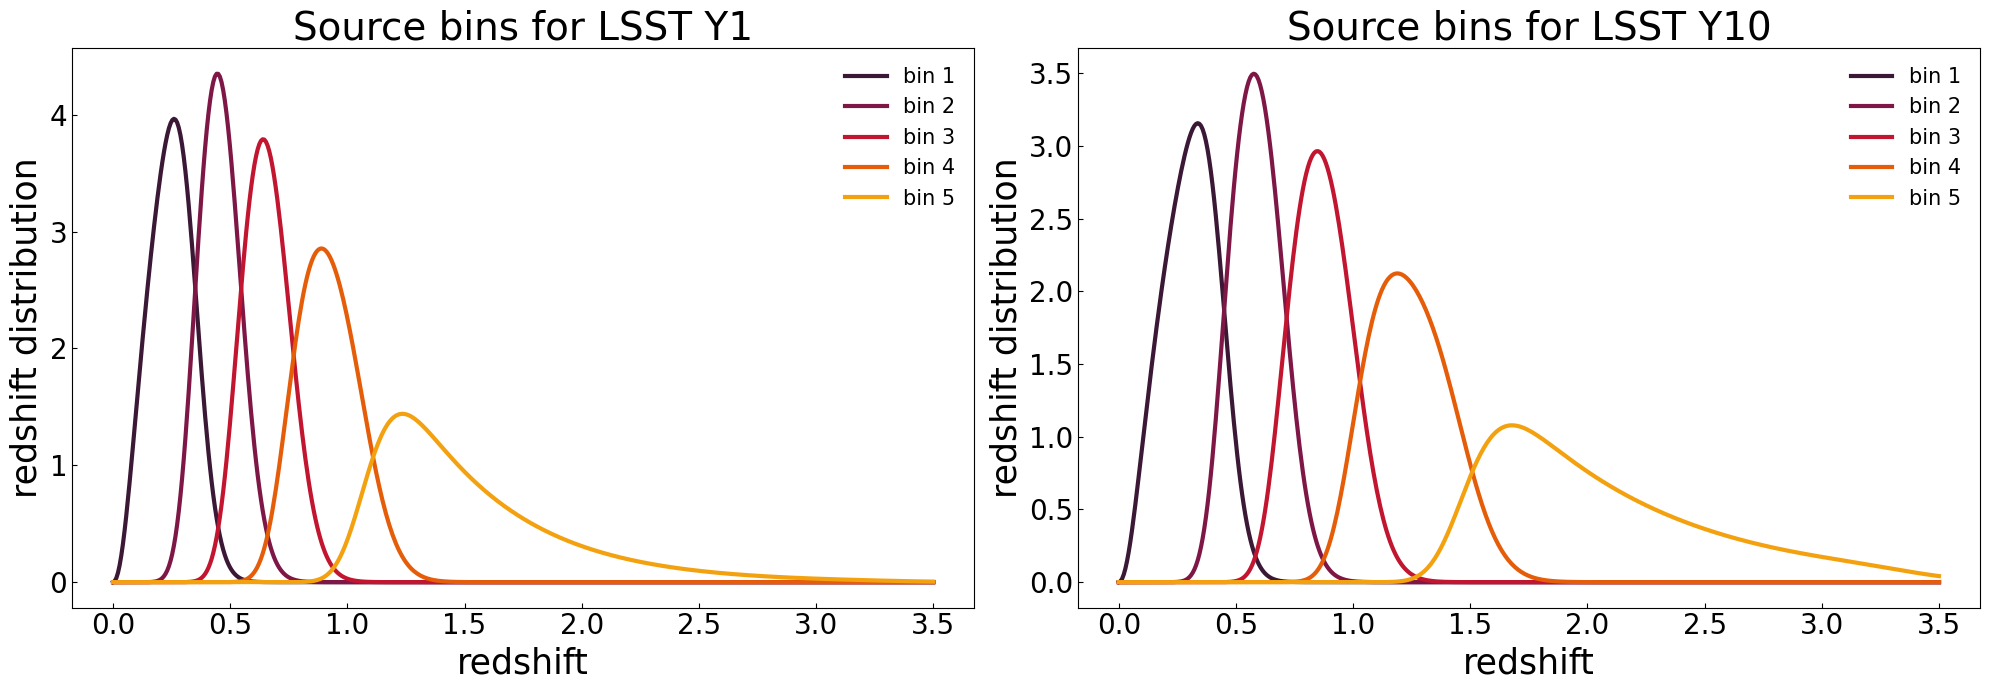

In [8]:
# Define parameters
years = ["1", "10"]
bin_type = "source_bins"
sample_type = "sources"

fig, axes = plt.subplots(1, 2, figsize=(20, 7))

for idx, year in enumerate(years):
    ax = axes[idx]
    for bin_idx, (key, data) in enumerate(samples[year][bin_type].items()):
        ax.plot(redshift_range,
                data,
                label=f"bin {key+1}",
                color=colors[sample_type][year][bin_idx],
                linestyle='-',
                lw=3)

    ax.set_xlabel("redshift")
    ax.set_ylabel("redshift distribution")
    ax.set_title(f"Source bins for LSST Y{year}")
    ax.tick_params(direction='in')
    ax.legend(frameon=False, ncol=1)
    ax.tick_params(axis='both', which='major')

plt.tight_layout()
plt.show()


### Print the bin centers
Finally, we print the bin centers for the source and lens samples for LSST Y1 and Y10.



In [9]:
# Print the bin centers
print(f"Source bin centers for Y1: {samples["1"]["source_bin_centers"]}")
print(f"Source bin centers for Y10: {samples["10"]["source_bin_centers"]}")
print(f"Lens bin centers for Y1: {samples["1"]["lens_bin_centers"]}")
print(f"Lens bin centers for Y10: {samples["10"]["lens_bin_centers"]}")


Source bin centers for Y1: {0: 0.251, 1: 0.456, 2: 0.655, 3: 0.917, 4: 1.527}
Source bin centers for Y10: {0: 0.309, 1: 0.589, 2: 0.867, 3: 1.241, 4: 2.053}
Lens bin centers for Y1: {0: 0.317, 1: 0.506, 2: 0.7, 3: 0.896, 4: 1.093}
Lens bin centers for Y10: {0: 0.263, 1: 0.359, 2: 0.456, 3: 0.555, 4: 0.653, 5: 0.752, 6: 0.851, 7: 0.95, 8: 1.049, 9: 1.149}


In [10]:
# If you wish to just print the bin centers as lists, you can do it this way:
for year in ["1", "10"]:
    source_bin_centers = list(samples[year]["source_bin_centers"].values())
    lens_bin_centers = list(samples[year]["lens_bin_centers"].values())

    print(f"Source bin centers for Y{year}: {source_bin_centers}")
    print(f"Lens bin centers for Y{year}: {lens_bin_centers}")

Source bin centers for Y1: [0.251, 0.456, 0.655, 0.917, 1.527]
Lens bin centers for Y1: [0.317, 0.506, 0.7, 0.896, 1.093]
Source bin centers for Y10: [0.309, 0.589, 0.867, 1.241, 2.053]
Lens bin centers for Y10: [0.263, 0.359, 0.456, 0.555, 0.653, 0.752, 0.851, 0.95, 1.049, 1.149]
